In [38]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [39]:
from src.data import extract_data
from src.utils import init_hydra


cfg = init_hydra("main")
df, _ = extract_data("v1.0", cfg)

In [40]:
df["Cancelled"].value_counts()

Cancelled
False    790105
True      25559
Name: count, dtype: int64

In [41]:
cancelled = df[df["Cancelled"]==True]
on_time = df[df["Cancelled"]==False]

In [42]:
cancelled.shape, on_time.shape

((25559, 61), (790105, 61))

In [43]:
representative_persent = (cancelled.shape[0]*100/on_time.shape[0]) / 100
print(representative_persent) 

0.032348865024268925


In [44]:
on_time = on_time.sample(frac=representative_persent)

In [45]:
import pandas as pd

df = pd.concat([cancelled,on_time])

In [46]:
df.shape

(51118, 61)

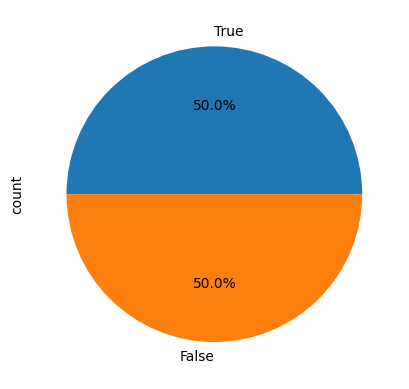

In [47]:
import matplotlib.pyplot as plt
# Plotting the pie chart
df["Cancelled"].value_counts().plot(kind='pie', autopct='%1.1f%%')  # autopct displays the percentage value

# Display the plot
plt.show()

In [48]:
df.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

# 1. Pull features

In [49]:
from pandas import DataFrame


def pull_features(df: DataFrame, required: list[str]) -> DataFrame:
    """
    Extract only the required features from the dataframe
    """
    # Check that the required columns are there
    for c in required:
        if c not in df.columns:
            raise ValueError(
                f"Dataframe lacks one or more of the required columns: {c}"
            )
    pulled_df = df.copy()
    columns_to_drop = set(df.columns) - set(required)

    pulled_df.drop(list(columns_to_drop), axis=1, inplace=True)

    return pulled_df

In [50]:
required: list[str] = cfg.required
df = pull_features(df, required)

# 2. Drop NaNs

In [51]:
print(df["Cancelled"].value_counts())
print(df.columns)

Cancelled
True     25559
False    25559
Name: count, dtype: int64
Index(['Airline', 'Origin', 'Dest', 'Cancelled', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'AirTime',
       'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Quarter', 'Month',
       'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network',
       'Operated_or_Branded_Code_Share_Partners',
       'IATA_Code_Marketing_Airline', 'Operating_Airline',
       'IATA_Code_Operating_Airline', 'OriginStateFips', 'OriginWac',
       'DestStateFips', 'DestWac', 'TaxiOut', 'WheelsOff', 'WheelsOn',
       'TaxiIn', 'CRSArrTime'],
      dtype='object')


In [52]:
# 2. Drop NaNs
df.dropna(axis=1, inplace=True)
df.isna().sum().sum()

0

In [53]:
print(df["Cancelled"].value_counts())
print(df.columns)

Cancelled
True     25559
False    25559
Name: count, dtype: int64
Index(['Airline', 'Origin', 'Dest', 'Cancelled', 'CRSDepTime',
       'CRSElapsedTime', 'Distance', 'Quarter', 'Month', 'DayofMonth',
       'DayOfWeek', 'Marketing_Airline_Network',
       'Operated_or_Branded_Code_Share_Partners',
       'IATA_Code_Marketing_Airline', 'Operating_Airline',
       'IATA_Code_Operating_Airline', 'OriginStateFips', 'OriginWac',
       'DestStateFips', 'DestWac', 'CRSArrTime'],
      dtype='object')


# 3. Fix and transfrom cyclic features

In [54]:
import hashlib
import numpy as np

from sklearn.pipeline import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclic_time_data(df: DataFrame, col: str, period: int) -> DataFrame:
    # Check that the column exists
    if col not in df.columns:
        raise ValueError(f"{col} is expected in the dataframe, but not found.")

    # Encode data
    df[col + "_sin"] = sin_transformer(period).fit_transform(df[col])
    df[col + "_cos"] = cos_transformer(period).fit_transform(df[col])

    # df.drop([col], axis=1, inplace=True)

    return df


def fix_hhmm(df: DataFrame, col: str) -> tuple[DataFrame, str, str]:
    # Encoding hours and minutes
    colHH = col + "HH"
    colMM = col + "MM"
    df[colHH] = df[col].apply(lambda hhmm: hhmm // 100)
    df[colMM] = df[col].apply(lambda hhmm: hhmm % 100)

    df.drop([col], axis=1, inplace=True)
    return (df, colHH, colMM)

In [55]:
# Fix hhmm columns
for c in cfg["hhmm"]:
    df, colHH, colMM = fix_hhmm(df, c)
    df = encode_cyclic_time_data(df, colHH, 24)
    df = encode_cyclic_time_data(df, colMM, 60)

In [56]:
# Transform cyclic features
for tf in cfg["time_features"]:
    df = encode_cyclic_time_data(df, tf[0], tf[1])

# 4. Feature crossing

In [57]:
def feature_cross(df: DataFrame, col1: str, col2: str):
    mean = df.groupby(col1)[col2].mean()
    df = df.merge(mean, on=col1, suffixes=("", f"_{col1}Mean"))


feature_cross(df, "DayofMonth", "Distance")
feature_cross(df, "Quarter", "Distance")

In [58]:
"DayofMonth_DistanceMean" in df.columns

False

# 5. One-hot encoding

In [59]:
# import pandas as pd

# df = pd.get_dummies(df, columns=df.columns[df.dtypes == 'object'])

In [60]:
len(df.columns)

44

# 6. Hashing

In [61]:
def hash_feature(df: DataFrame, col: str, num_buckets=1000):
    # Hashing with buckets
    df[col] = df[col].map(
        lambda text: int(hashlib.md5(text.encode()).hexdigest(), 16) % num_buckets
    )
    return df

In [62]:
for c in df.columns[df.dtypes == "object"]:
    df = hash_feature(df, c, 10)

In [63]:
# print(df.shape, dff.shape)

In [64]:
# df = pd.concat([df, dff.drop(['Cancelled'], axis=1)], axis=1)
# df

## Taking a random sample, for performance

In [65]:
X = df.drop(["Cancelled"], axis=1)
y = df["Cancelled"]

In [66]:
y.value_counts()

Cancelled
True     25559
False    25559
Name: count, dtype: int64

# 6. Scale features

In [67]:
# NOT REQUIRED FOR XGBOOST

# from sklearn.discriminant_analysis import StandardScaler


# sc = StandardScaler()

# df = sc.fit_transform(X)
# df

In [68]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=1,
)

In [69]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(
    random_state=1,
)
rus = RandomUnderSampler(
    random_state=1,
)

In [70]:
print(np.bincount(y_train))

X_train, y_train = ros.fit_resample(X_train, y_train)

print(np.bincount(y_train))

[20447 20447]
[20447 20447]


In [71]:
X_train.dtypes.value_counts()

float64    23
int64      20
Name: count, dtype: int64

# Leaving only Top Gs

In [72]:
top_gs = [
    "Quarter",
    "Marketing_Airline_Network",
    "DayofMonth",
    "Operated_or_Branded_Code_Share_Partners",
    "Airline",
    "Operating_Airline",
    "OriginWac",
    "DayofMonth_sin",
    "DayOfWeek",
    "DestWac",
    "CRSDepTimeHH",
]

df.drop(
    list(set(df.columns) - set(top_gs)),
    axis=1,
    inplace=True,
)

In [73]:
df

,Airline,Quarter,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,Operating_Airline,OriginWac,DestWac,CRSDepTimeHH,DayofMonth_sin
948,9,2,2,6,1,5,6,33,74,18,0.394356
969,9,2,2,6,1,5,6,74,33,14,0.394356
981,9,2,2,6,1,5,6,74,33,14,0.394356
1000,9,2,2,6,1,5,6,33,74,16,0.394356
1450,1,2,1,5,1,5,0,22,21,7,0.201299
...,...,...,...,...,...,...,...,...,...,...,...
444096,0,2,5,2,4,8,6,36,12,17,0.848644
255036,7,2,24,7,5,5,5,91,74,13,-0.988468
180726,7,2,4,1,4,4,4,38,74,6,0.724793
132892,5,2,16,6,5,9,0,64,22,13,-0.101168


# Training the model

In [74]:
X_train

,Airline,Origin,Dest,Distance,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,...,CRSElapsedTimeMM_sin,CRSElapsedTimeMM_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayofMonth_sin,DayofMonth_cos,Quarter_sin,Quarter_cos
0,7,9,3,2454.0,2,4,8,5,5,5,...,1.000000,3.061617e-16,0.866025,-0.5,-0.974928,-0.222521,0.998717,-0.050649,1.224647e-16,-1.000000e+00
1,1,9,8,746.0,2,4,26,2,1,1,...,-0.866025,5.000000e-01,0.866025,-0.5,0.974928,-0.222521,-0.848644,0.528964,1.224647e-16,-1.000000e+00
2,7,9,3,814.0,1,2,5,6,4,4,...,0.309017,-9.510565e-01,0.866025,0.5,-0.781831,0.623490,0.848644,0.528964,1.000000e+00,6.123234e-17
3,4,2,5,848.0,1,2,21,1,1,5,...,-0.743145,-6.691306e-01,0.866025,0.5,0.781831,0.623490,-0.897805,-0.440394,1.000000e+00,6.123234e-17
4,5,4,5,756.0,1,2,3,4,3,3,...,1.000000,6.123234e-17,0.866025,0.5,-0.433884,-0.900969,0.571268,0.820763,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40889,4,7,8,152.0,2,4,22,5,1,5,...,0.309017,9.510565e-01,0.866025,-0.5,-0.974928,-0.222521,-0.968077,-0.250653,1.224647e-16,-1.000000e+00
40890,5,4,3,1476.0,1,2,4,5,3,3,...,-0.500000,-8.660254e-01,0.866025,0.5,-0.974928,-0.222521,0.724793,0.688967,1.000000e+00,6.123234e-17
40891,1,1,5,760.0,2,4,1,5,1,1,...,-0.309017,-9.510565e-01,0.866025,-0.5,-0.974928,-0.222521,0.201299,0.979530,1.224647e-16,-1.000000e+00
40892,5,8,7,1109.0,2,4,7,4,3,3,...,0.500000,8.660254e-01,0.866025,-0.5,-0.433884,-0.900969,0.988468,0.151428,1.224647e-16,-1.000000e+00


In [76]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1500,random_state=42,max_depth=1500)

rf.fit(X_train.values, y_train.values)

RandomForestClassifier(max_depth=1500, n_estimators=1500, random_state=42)

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    random_state=42,
    n_estimators=1500,
    learning_rate=0.1,
    max_depth=1500,
    subsample=0.999,
    colsample_bytree=0.9999999,
    tree_method="hist",
    
)
xgb.fit(X_train.values, y_train.values)

Accuracy: 0.8568075117370892
F1 score: 0.857
Recall: 0.857
Precision: 0.857
AUC Score: 0.857
Classification report:
               precision    recall  f1-score   support

       False       0.85      0.87      0.86      5112
        True       0.87      0.84      0.85      5112

    accuracy                           0.86     10224
   macro avg       0.86      0.86      0.86     10224
weighted avg       0.86      0.86      0.86     10224

Confusion Matrix:


<Axes: >

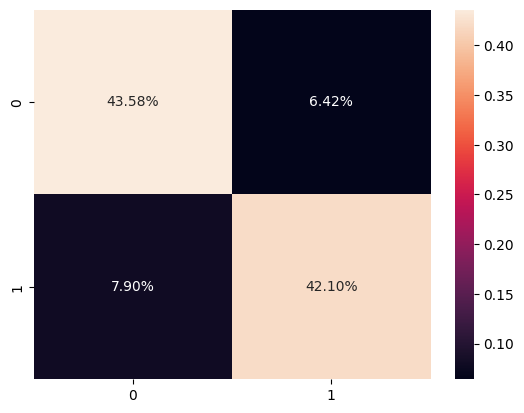

In [77]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
import seaborn as sn


y_pred = rf.predict(X_test.values)
print("Accuracy:", accuracy_score(y_pred, y_test))
print("F1 score: %.3f" % f1_score(y_test, y_pred, average="weighted"))
print("Recall: %.3f" % recall_score(y_test, y_pred, average="weighted"))
print("Precision: %.3f" % precision_score(y_test, y_pred, average="weighted"))
print("AUC Score: %.3f" % roc_auc_score(y_test, y_pred, average="weighted"))

print("Classification report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred)
sn.heatmap(conf_mat/np.sum(conf_mat), annot=True,  fmt='.2%')

In [ ]:
import matplotlib.pyplot as plt

# Accessing feature importances
feature_importances = xgb.feature_importances_

# Pairing feature names with their importance scores
features = X.columns
importance_scores = list(zip(features, feature_importances))

# Sorting the features by importance
sorted_importance_scores = sorted(importance_scores, key=lambda x: x[1], reverse=True)

# Plotting the feature importance graph
plt.figure(figsize=(12, 8))
plt.bar(
    range(len(sorted_importance_scores)),
    [score[1] for score in sorted_importance_scores],
)
plt.xticks(
    range(len(sorted_importance_scores)),
    [score[0] for score in sorted_importance_scores],
    rotation=90,
)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
# sorted_importance_scores = [s[0] for s in sorted_importance_scores if s[1] >= 0.02]
sorted_importance_scores

In [78]:
from src.data import extract_data
from src.utils import init_hydra


cfg = init_hydra("main")
df, _ = extract_data("v2.0", cfg)

In [79]:
required: list[str] = cfg.required
df = pull_features(df, required)

df.dropna(axis=1, inplace=True)
df.isna().sum().sum()

import hashlib
import numpy as np

from sklearn.pipeline import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclic_time_data(df: DataFrame, col: str, period: int) -> DataFrame:
    # Check that the column exists
    if col not in df.columns:
        raise ValueError(f"{col} is expected in the dataframe, but not found.")

    # Encode data
    df[col + "_sin"] = sin_transformer(period).fit_transform(df[col])
    df[col + "_cos"] = cos_transformer(period).fit_transform(df[col])

    # df.drop([col], axis=1, inplace=True)

    return df


def fix_hhmm(df: DataFrame, col: str) -> tuple[DataFrame, str, str]:
    # Encoding hours and minutes
    colHH = col + "HH"
    colMM = col + "MM"
    df[colHH] = df[col].apply(lambda hhmm: hhmm // 100)
    df[colMM] = df[col].apply(lambda hhmm: hhmm % 100)

    df.drop([col], axis=1, inplace=True)
    return (df, colHH, colMM)


# Fix hhmm columns
for c in cfg["hhmm"]:
    df, colHH, colMM = fix_hhmm(df, c)
    df = encode_cyclic_time_data(df, colHH, 24)
    df = encode_cyclic_time_data(df, colMM, 60)
    
    
# Transform cyclic features
for tf in cfg["time_features"]:
    df = encode_cyclic_time_data(df, tf[0], tf[1])
    
    



for c in df.columns[df.dtypes == "object"]:
    df = hash_feature(df, c, 10)
    
# top_gs = [
#     "Quarter",
#     "Marketing_Airline_Network",
#     "DayofMonth",
#     "Operated_or_Branded_Code_Share_Partners",
#     "Airline",
#     "Operating_Airline",
#     "OriginWac",
#     "DayofMonth_sin",
#     "DayOfWeek",
#     "DestWac",
#     "CRSDepTimeHH",
#     "Cancelled"
# ]

# df.drop(
#     list(set(df.columns) - set(top_gs)),
#     axis=1,
#     inplace=True,
# )
    
X = df.drop(["Cancelled"], axis=1)
y = df["Cancelled"]

In [ ]:
X.shape

Accuracy: 0.851894897899135
F1 score: 0.900
Recall: 0.852
Precision: 0.963
AUC Score: 0.681
Classification report:
               precision    recall  f1-score   support

       False       0.99      0.86      0.92    795526
        True       0.08      0.50      0.14     20138

    accuracy                           0.85    815664
   macro avg       0.53      0.68      0.53    815664
weighted avg       0.96      0.85      0.90    815664

Confusion Matrix:


<Axes: >

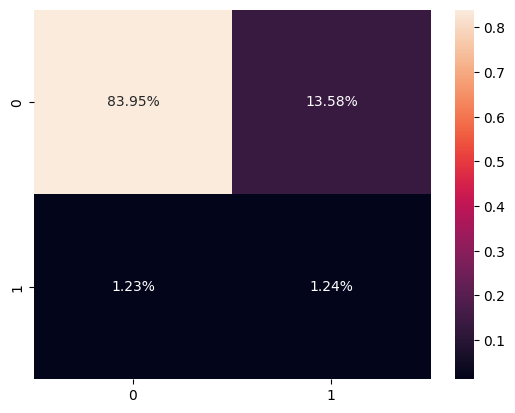

In [80]:

y_pred = rf.predict(X.values)
print("Accuracy:", accuracy_score(y_pred, y))
print("F1 score: %.3f" % f1_score(y, y_pred, average="weighted"))
print("Recall: %.3f" % recall_score(y, y_pred, average="weighted"))
print("Precision: %.3f" % precision_score(y, y_pred, average="weighted"))
print("AUC Score: %.3f" % roc_auc_score(y, y_pred, average="weighted"))

print("Classification report:\n", classification_report(y, y_pred))

print("Confusion Matrix:")
conf_mat = confusion_matrix(y, y_pred)
sn.heatmap(conf_mat/np.sum(conf_mat), annot=True,  fmt='.2%')